In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle as astropy_ls

import matplotlib 
matplotlib.rc('xtick', labelsize=23) 
matplotlib.rc('ytick', labelsize=23) 
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)


In [2]:
data = pd.read_csv('kepler1513_ttvs_final.csv', sep=',')
times = data['times'].values
times_err_low = data['times_low_err'].values
times_err_high = data['times_high_err'].values
times_err = np.mean([times_err_low, times_err_high], axis=0)
epochs = data['epochs'].values+1




times_err

array([0.00039101, 0.00042965, 0.00047064, 0.00040953, 0.00043052,
       0.00036012, 0.00041387, 0.00036716, 0.00332388, 0.00159477])

In [3]:
# p = 160.88409 + 7e-05 - 7e-05 from transit model
# t0 = 277.50639 + 0.00031 - 0.00031 from transit model

period = 160.88409 
t0 = 277.50639 

linear_ephemeris_times = []
for epoch in epochs:
    linear_ephemeris_times.append(t0+period*(epoch-1))
    
    
linear_ephemeris_times = np.array(linear_ephemeris_times)
print(linear_ephemeris_times)

[ 277.50639  438.39048  760.15866  921.04275 1081.92684 1242.81093
 1403.69502 1564.57911 4943.145   5264.91318]


In [4]:
Pmin = 2
Pmax = 100
fmin = 1/Pmax
fmax = 1/Pmin

fgrid = np.arange(fmin, fmax, 0.1*fmin)
Pgrid = np.sort(1/fgrid)



In [5]:
from scipy import optimize

def get_times_model(epochs, T0, P, alpha_ttv, beta_ttv): 
    return T0 + P*epochs + alpha_ttv*np.sin((2*np.pi*epochs/ P_ttv)) +  beta_ttv*np.cos((2*np.pi*epochs/ P_ttv))

def get_times_null_model(epochs, T0, P): 
    return T0 + P*epochs

def get_chisq(times, times_model, times_err):
    chisq = 0
    for ii in range(0, len(times)):
        chisq += ( ((times_model[ii] - times[ii])**2) / (times_err[ii]**2) )
    

    return chisq

In [6]:
def get_times_model_2waves(epochs, T0, P, alpha1_ttv, beta1_ttv, alpha2_ttv, beta2_ttv, P1_ttv): 
    linear = P*epochs
    wave1 = alpha1_ttv*np.sin((2*np.pi*epochs/ P1_ttv)) +  beta1_ttv*np.cos((2*np.pi*epochs/ P1_ttv))
    wave2 = alpha2_ttv*np.sin((2*np.pi*epochs/ P2_ttv)) +  beta2_ttv*np.cos((2*np.pi*epochs/ P2_ttv))
    
    return T0 + linear + wave1 + wave2
    

In [7]:
epochs_kepler, times_kepler, times_err_kepler = epochs[0:8], times[0:8], times_err[0:8]
null_model_kepler,_  = optimize.curve_fit(get_times_null_model, epochs_kepler, times_kepler, sigma=times_err_kepler, absolute_sigma = True)
times_null_model = get_times_null_model(epochs_kepler, *null_model_kepler)
null_chisq = get_chisq(times_kepler, times_null_model, times_err_kepler)



chisq_grid_kepler = []
for P_ttv in Pgrid:
    a_model,_  = optimize.curve_fit(get_times_model, epochs_kepler, times_kepler, sigma=times_err_kepler, absolute_sigma = True)
    times_a_model = get_times_model(epochs_kepler, *a_model)
    a_chisq = get_chisq(times_kepler, times_a_model, times_err_kepler)
    delta_chisq = null_chisq - a_chisq
    chisq_grid_kepler.append(delta_chisq)

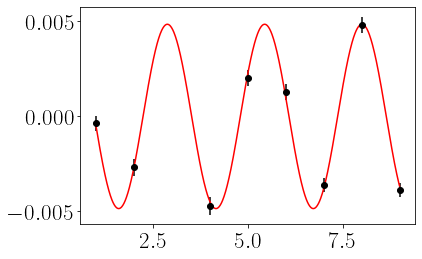

In [8]:
#find max chisq fast ttv
max_fast_chisq = 0
max_fast_ind = None
max_fast_period = None
for ii in range(0, len(chisq_grid_kepler)):
    chisq = chisq_grid_kepler[ii]
    period = Pgrid[ii]
    if chisq > max_fast_chisq:
        max_fast_ind = ii
        max_fast_chisq = chisq
        max_fast_period = period
        
        
#recalculate the max-chisq model
epochs_plot = np.arange(np.min(epochs_kepler), np.max(epochs_kepler), 0.01)
P_ttv = max_fast_period
max_model,_  = optimize.curve_fit(get_times_model, epochs_kepler, times_kepler, sigma=times_err_kepler, absolute_sigma = True)  
ttvs_max_model = get_times_model(epochs_plot, *max_model) - get_times_null_model(epochs_plot, *max_model[0:2])

ttvs_input = times_kepler - get_times_null_model(epochs_kepler, *max_model[0:2])

plt.errorbar(epochs_kepler, ttvs_input, yerr=times_err_kepler, ls='', marker='o', color='k')
plt.plot(epochs_plot, ttvs_max_model, 'r')

In [9]:
null_model,_  = optimize.curve_fit(get_times_null_model, epochs, times, sigma=times_err, absolute_sigma = True)
times_null_model = get_times_null_model(epochs, *null_model)
null_chisq = get_chisq(times, times_null_model, times_err)


chisq_grid_fast = []
for P_ttv in Pgrid:
    a_model,_  = optimize.curve_fit(get_times_model, epochs, times, sigma=times_err, absolute_sigma = True)
    times_a_model = get_times_model(epochs, *a_model)
    a_chisq = get_chisq(times, times_a_model, times_err)
    delta_chisq = null_chisq - a_chisq
    chisq_grid_fast.append(delta_chisq)
    

In [10]:
print(times_err)

[0.00039101 0.00042965 0.00047064 0.00040953 0.00043052 0.00036012
 0.00041387 0.00036716 0.00332388 0.00159477]


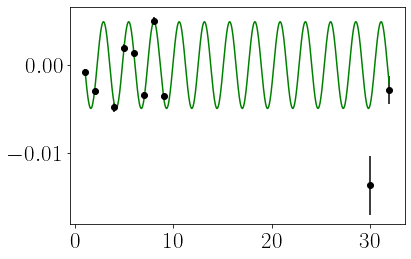

In [11]:
#find max chisq fast ttv
max_fast_chisq = 0
max_fast_ind = None
max_fast_period = None
for ii in range(0, len(chisq_grid_fast)):
    chisq = chisq_grid_fast[ii]
    period = Pgrid[ii]
    if chisq > max_fast_chisq:
        max_fast_ind = ii
        max_fast_chisq = chisq
        max_fast_period = period
        
        
#recalculate the max-chisq model
epochs_plot = np.arange(np.min(epochs), np.max(epochs), 0.01)
P_ttv = max_fast_period
max_fast_model,_  = optimize.curve_fit(get_times_model, epochs, times, sigma=times_err, absolute_sigma = True)  
ttvs_max_fast_model = get_times_model(epochs_plot, *max_fast_model) - get_times_null_model(epochs_plot, *max_fast_model[0:2])

ttvs_input = times - get_times_null_model(epochs, *max_fast_model[0:2])

plt.errorbar(epochs, ttvs_input, yerr=times_err, ls='', marker='o', color='k')
plt.plot(epochs_plot, ttvs_max_fast_model, 'g')


In [12]:
#determine max 2 ttv chisq
chisq_1ttv = get_chisq(times, 
                       get_times_model(epochs, *max_fast_model),
                       times_err)

print(chisq_1ttv)


11.262623086506593


In [13]:

p_guess = np.append(max_fast_model, [0,0,max_fast_period])
p_guess

array([1.16622072e+02, 1.60884338e+02, 3.38945746e-03, 3.58462392e-03,
       0.00000000e+00, 0.00000000e+00, 2.57069409e+00])

In [14]:
null_model,_  = optimize.curve_fit(get_times_null_model, epochs, times, sigma=times_err, absolute_sigma = True)
times_null_model = get_times_null_model(epochs, *null_model)
null_chisq = get_chisq(times, times_null_model, times_err)


chisq_grid = []
p_guess = np.append(max_fast_model, [0,0,max_fast_period])
for P2_ttv in Pgrid:
    #P2_ttv = max_fast_period
    a_model,_  = optimize.curve_fit(get_times_model_2waves, epochs, times, 
                                    sigma=times_err, absolute_sigma = True,p0 = p_guess)
    times_a_model = get_times_model_2waves(epochs, *a_model)
    a_chisq = get_chisq(times, times_a_model, times_err)
    delta_chisq = null_chisq - max_fast_chisq - a_chisq

    chisq_grid.append(delta_chisq)

/Users/daniel/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [15]:
chisq_total_grid = []
p_guess = np.append(max_fast_model, [0,0,max_fast_period])
for P2_ttv in Pgrid:
    #P2_ttv = max_fast_period
    a_model,_  = optimize.curve_fit(get_times_model_2waves, epochs, times, 
                                    sigma=times_err, absolute_sigma = True,p0 = p_guess)
    times_a_model = get_times_model_2waves(epochs, *a_model)
    a_chisq = get_chisq(times, times_a_model, times_err)
    delta_chisq = null_chisq - a_chisq

    chisq_total_grid.append(delta_chisq)

8.928571428571436
[ 1.16622754e+02  1.60884173e+02  2.83131058e-03  3.83083358e-03
 -9.46426407e-04  3.99982535e-04  2.59806278e+00]


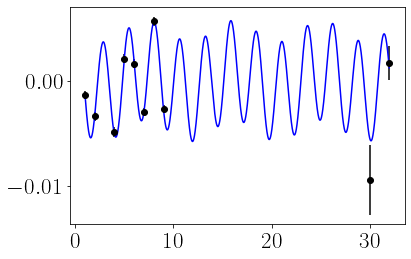

In [16]:
#find max chisq slow ttv
max_slow_chisq = 0
max_slow_ind = None
max_slow_period = None
for ii in range(0, len(chisq_grid)):
    chisq = chisq_grid[ii]
    period = Pgrid[ii]
    if chisq > max_slow_chisq:
        max_slow_ind = ii
        max_slow_chisq = chisq
        max_slow_period = period
        
        
#recalculate the max-chisq model
epochs_plot = np.arange(np.min(epochs), np.max(epochs), 0.01)
P2_ttv = max_slow_period
print(P2_ttv)
max_model,_  = optimize.curve_fit(get_times_model_2waves, epochs, times, 
                                  sigma=times_err, absolute_sigma = True, p0=p_guess)
print(max_model)
ttvs_max_model = get_times_model_2waves(epochs_plot, *max_model) - get_times_null_model(epochs_plot, *max_model[0:2])

ttvs_input = times - get_times_null_model(epochs, *max_model[0:2])

plt.errorbar(epochs, ttvs_input, yerr=times_err, ls='', marker='o', color='k')
plt.plot(epochs_plot, ttvs_max_model, 'b')

In [17]:
#determine max 2 ttv chisq
chisq_2ttv = get_chisq(times, get_times_model_2waves(epochs, *max_model), times_err)



print(chisq_2ttv)



2.366608245428898


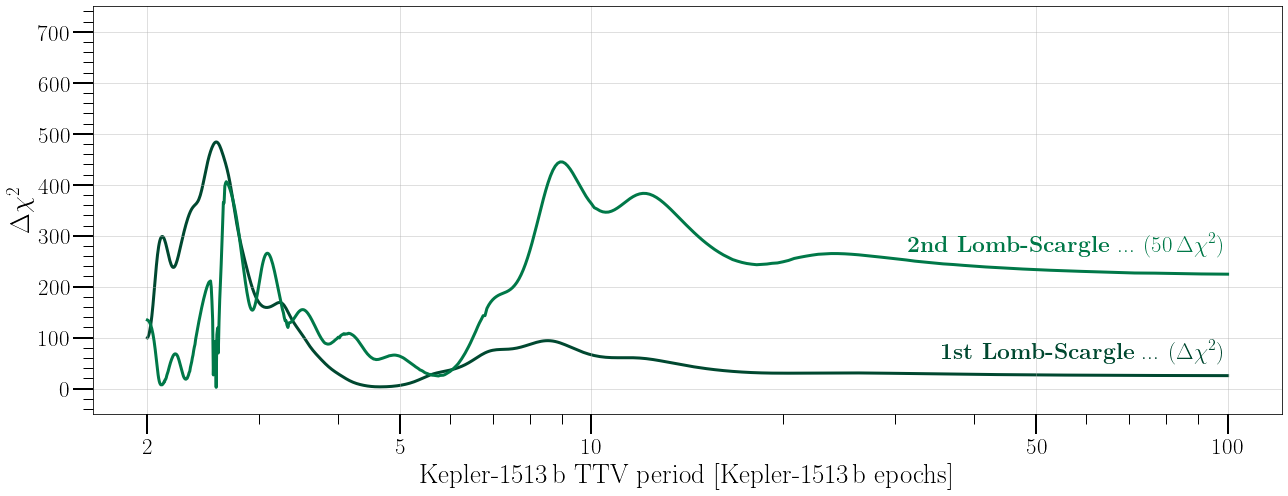

In [18]:
fig, ax = plt.subplots(1, figsize=[18, 7])


ax.plot(Pgrid, 50*np.array(chisq_grid), color="#007848", ls='-', lw=3)
ax.plot(Pgrid, chisq_grid_fast, color="#004830", lw=3, ls='-', zorder=-100)


ax.set_xlabel(r'Kepler-1513\,b TTV period [Kepler-1513\,b epochs]', fontsize=27)
ax.set_ylabel(r'$\Delta \chi ^2$', fontsize=27)

ax.set_xscale('log')


ax.grid(visible=True, alpha=0.5)
ax.set_xticks([2, 5, 10, 50, 100])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


ax.text(99, 270, r'\textbf{2nd Lomb-Scargle} ... (50\,$\Delta \chi^2$)', color = '#007848', fontsize=23, horizontalalignment='right')
ax.text(99, 60, r'\textbf{1st Lomb-Scargle} ... ($\Delta \chi^2$)', color = '#004830', fontsize=23, horizontalalignment='right')

#ax.text(6, 530, r'\textbf{Lomb-Scargle Periodogram}', color = 'k', fontsize=27, horizontalalignment='center')

# We change the length of ticks 
ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
ax.minorticks_on()

plt.ylim(-50, 750)



plt.tight_layout()
plt.savefig('periodogram_2ttvs.pdf')

plt.show()


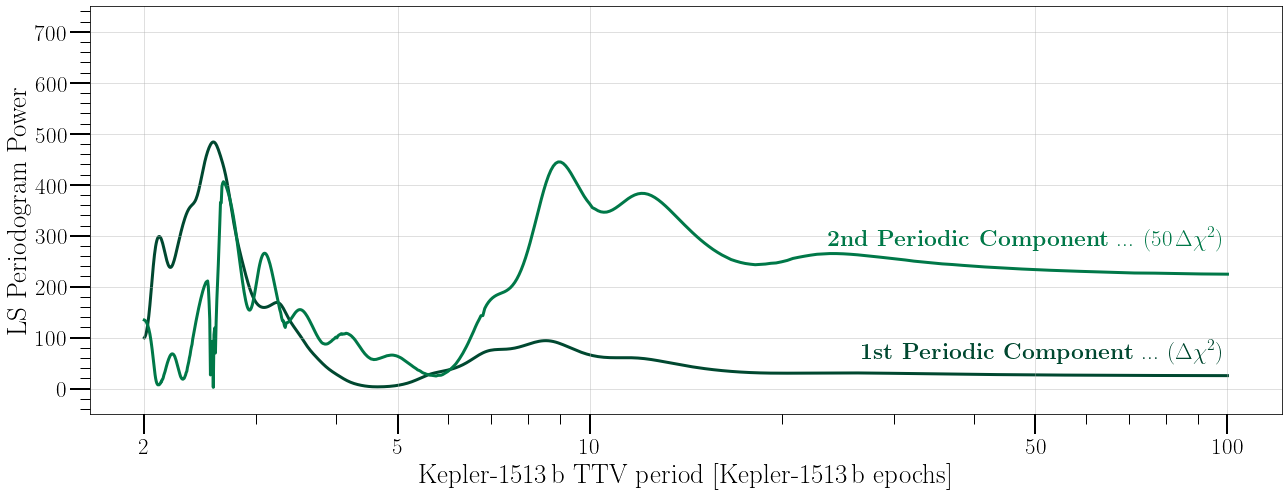

In [26]:
fig, ax = plt.subplots(1, figsize=[18, 7])


ax.plot(Pgrid, 50*np.array(chisq_grid), color="#007848", ls='-', lw=3)
ax.plot(Pgrid, chisq_grid_fast, color="#004830", lw=3, ls='-', zorder=-100)


ax.set_xlabel(r'Kepler-1513\,b TTV period [Kepler-1513\,b epochs]', fontsize=27)
ax.set_ylabel(r'LS Periodogram Power', fontsize=27)

ax.set_xscale('log')


ax.grid(visible=True, alpha=0.5)
ax.set_xticks([2, 5, 10, 50, 100])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


ax.text(99, 280, r'\textbf{2nd Periodic Component} ... (50\,$\Delta \chi^2$)', color = '#007848', fontsize=23, horizontalalignment='right')
ax.text(99, 60, r'\textbf{1st Periodic Component} ... ($\Delta \chi^2$)', color = '#004830', fontsize=23, horizontalalignment='right')

#ax.text(6, 530, r'\textbf{Lomb-Scargle Periodogram}', color = 'k', fontsize=27, horizontalalignment='center')

# We change the length of ticks 
ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
ax.minorticks_on()

plt.ylim(-50, 750)



plt.tight_layout()
plt.savefig('periodogram_2ttvs_twitter.pdf')

plt.show()

In [19]:
def BIC(chi2, k, N):
    #k = the number of parameters estimated by the model
    #N = the number of data points
    #chi2 = chi2
    return chi2 + k*np.log(N)

def AIC(chi2, k):
    #k = the number of parameters estimated by the model
    #N = the number of data points
    #chi2 = chi2
    return chi2 + 2*k


def AICc(chi2, k, N):
    #k = the number of parameters estimated by the model
    #N = the number of data points
    #chi2 = chi2
    return (chi2 + 2*k) + (2*k**2. + 2*k)/(N - k - 1)

In [20]:
#2 ttv model params:
#T0, P, alpha1_ttv, beta1_ttv, alpha2_ttv, beta2_ttv, P1_ttv
#so k = 7

#1 ttv model params:
#T0, P, alpha1_ttv, beta1_ttv
#so k = 4

print("DONT THINK BIC IS A GOOD METRIC BC N ~ k")
print('double sinusoid BIC: ' + str(BIC(chisq_2ttv, 7, len(times))))
print('single sinusoid BIC: ' + str(BIC(chisq_1ttv, 4, len(times))))


print('')
print('')


print('double sinusoid AIC: ' + str(AIC(chisq_2ttv, 7)))
print('single sinusoid AIC: ' + str(AIC(chisq_1ttv, 4)))


print('')
print('')


print('double sinusoid AICc: ' + str(AICc(chisq_2ttv, 7, len(times))))
print('single sinusoid AICc: ' + str(AICc(chisq_1ttv, 4, len(times))))




DONT THINK BIC IS A GOOD METRIC BC N ~ k
double sinusoid BIC: 18.484703896387217
single sinusoid BIC: 20.472963458482777


double sinusoid AIC: 16.3666082454289
single sinusoid AIC: 19.262623086506593


double sinusoid AICc: 72.36660824542889
single sinusoid AICc: 27.262623086506593
